### Adam Ismaili - Noé Topeza - IMAGE

# PROJET - IML

## Introduction

Les données mises à notre disposition dans le cadre de ce projet sont celles du IEEE GRSS Data Fusion Contest 2013, étant un challenge organisé par certains membres de l'IEEE (Institute of Electrical and Electronics Engineers) mettant en oeuvre des problématiques de fusion d'information. 

Elles sont composées de deux images vues du dessus de l'université de Houston en 2012.

Les images en question sont une image hyperspectrale de 144 bandes couvrant la portion 380−1050 nm du spectre éléctromagnétique, ainsi qu'une image LiDAR.

Nous disposons également de données concernant la vérité de terrain, décrivant notamment les 15 classes que peuvent prendre nos pixels, visibles ci-dessous.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import io
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score
from skimage.morphology import disk, erosion, closing, opening
from skimage.segmentation import flood_fill
from skimage.exposure import equalize_adapthist
from skimage.filters import gaussian

In [2]:
# Extraction des données des deux images
data = sp.io.loadmat('data/2013_DFC_contest.mat')

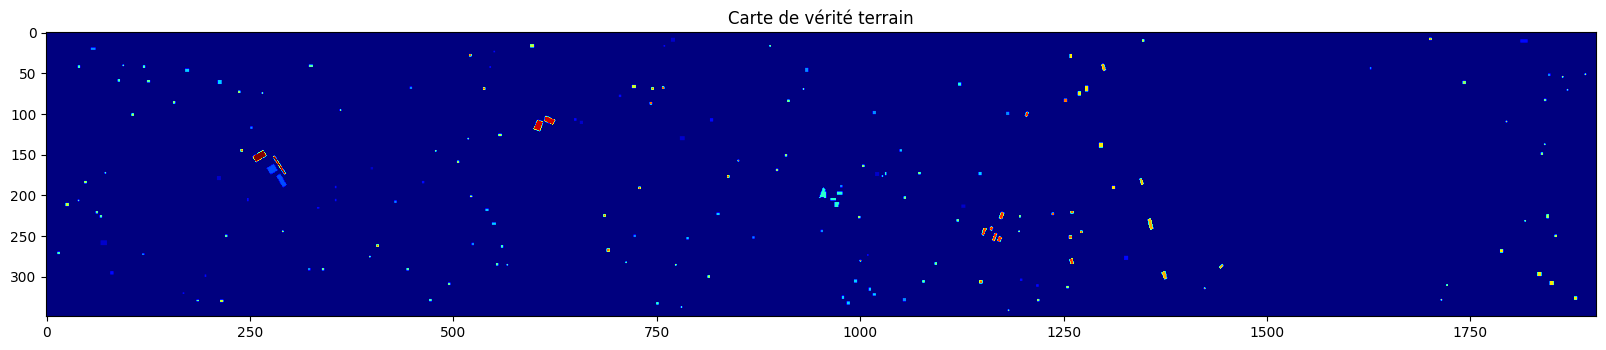

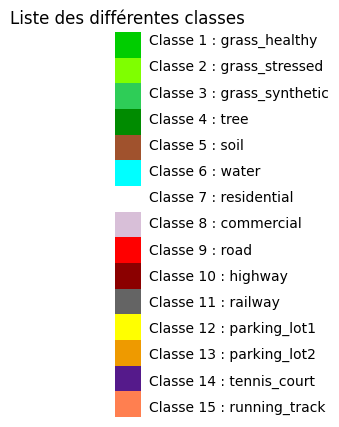

In [3]:
# Extraction des données sur la vérité de terrain
groundtruth_raw = np.load('groundtruth/groundtruth.npy')

groundtruth_info = np.load('groundtruth/groundtruth_info.npy', allow_pickle=True)

plt.figure(figsize=(20,5))
plt.title('Carte de vérité terrain')
plt.imshow(groundtruth_raw, cmap='jet')

plt.show()

cls_rgb = []
for ii in groundtruth_info:
    cls_rgb.append(ii['class_color'])
cls_rgb = np.array(cls_rgb).reshape(15,-1,3)

plt.figure(figsize=(5,5))
plt.title('Liste des différentes classes')
plt.imshow(cls_rgb)
plt.axis('off')
for cls in range(15):
        plt.text(0.85, 1.02 * cls,'Classe %d : %s'%(cls + 1,groundtruth_info[cls]['class_name']))
        
plt.show()

Ainsi, l'objectif du projet est d'effectuer la classification sémantique des pixels de la scène, soit assigner à chaque pixel l'identifiant de la classe à laquelle il appartient.

Pour répondre au problème, nous effectuerons tout d'abord certains (pré-)traitements sur l'image hyperspectrale, puis sur l'image LiDAR, avant de classer nos données par l'usage d'un classifieur entrainé et testé.

## I. Traitements de l'Image Hyperspectrale

L'image hyperspectrale peut être représentée par un cube de largeur 349, de longueur 1905, et de profondeur 144 ; la dernière dimension étant les bandes du spectre éléctromagnetique, soient les caractéristiques composant chaque pixel.

Une version de l'image hyperspectrale sur les bandes RGB est visible ci-dessous.

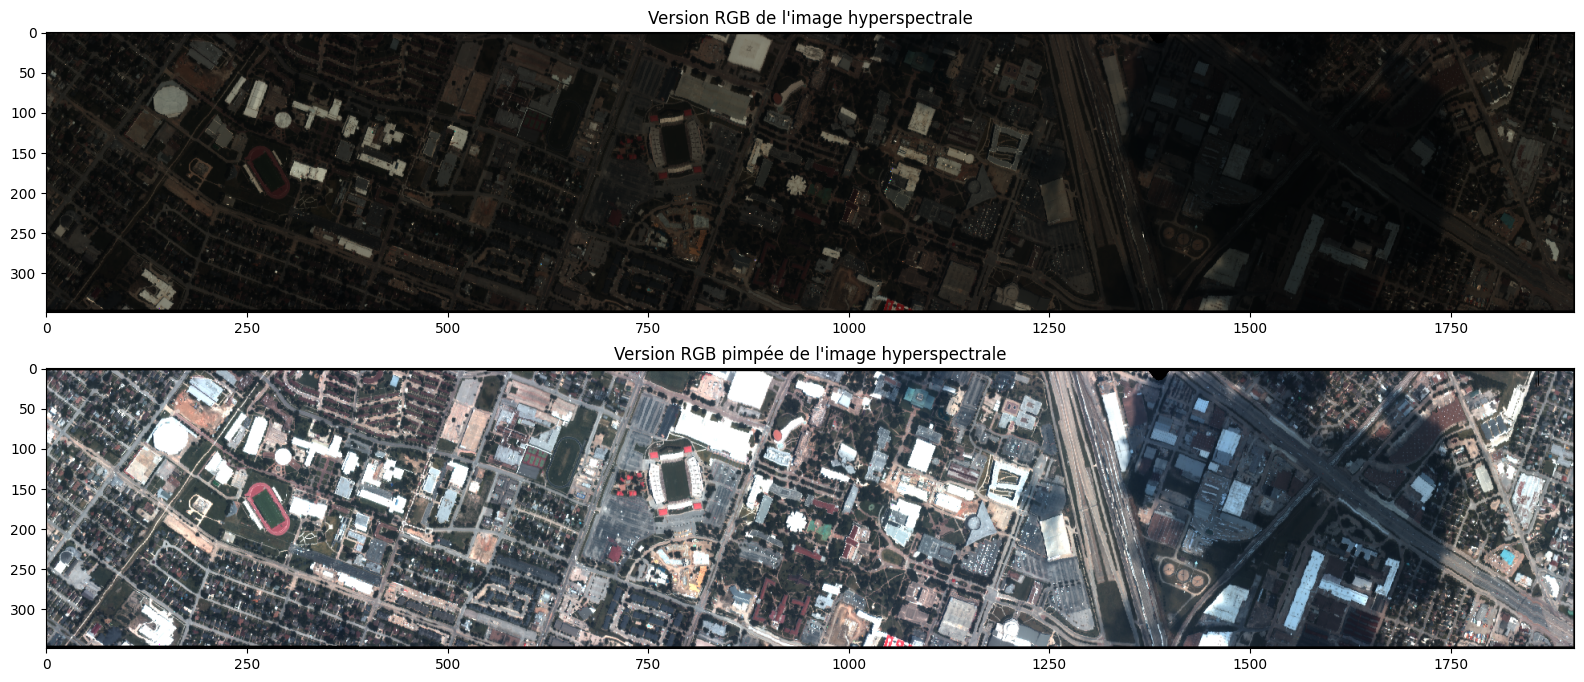

In [4]:
## Applying PCA to hyperspectral image (= hsi)

hsi_raw = data["hyper"]

# Plotting hsi in rgb bands
rgb_bands = [54, 32, 18]
hsi_rgb = hsi_raw[:, :, rgb_bands]
hsi_rgb = hsi_rgb / hsi_rgb.max()

# -- Pimping the rgb image -- 
pmin,pmax = np.percentile(hsi_rgb, (1, 95), axis=(0,1))
hsi_rgb_pimped = hsi_rgb.copy()
for i in range(pmin.size):
    hsi_rgb_pimped[:, :, i] = (hsi_rgb[:, :, i] - pmin[i]) / (pmax[i] - pmin[i])
hsi_rgb_pimped[hsi_rgb_pimped < 0] = 0
hsi_rgb_pimped[hsi_rgb_pimped > 1] = 1

plt.figure(figsize=(20,8))
plt.subplot(211)
plt.title("Version RGB de l'image hyperspectrale")
plt.imshow(hsi_rgb)

plt.subplot(212)
plt.title("Version RGB pimpée de l'image hyperspectrale")
plt.imshow(hsi_rgb_pimped)

plt.show()

### A. Traitements par PCA

Un premier problème qui se pose est le nombre de caractéristiques élevé composant chacun de nos pixels. En effet, des phénomènes embêtant et contre-intuitifs peuvent se produire lorsque l'on travaille sur des données de grande dimension, rassemblés sous le nom du "fléau de la dimensionnalité" (= curse of dimensionality). 

Ainsi, la première étape de création de notre algorithme consiste à réduire la dimension de l'espace des caractéristiques dans lequel le modèle va fonctionner.

Pour se faire, nous allons appliquer la méthode PCA, soit l'Analyse en Composantes Principales (= Principal Components Analysis), sur notre image hyperspectrale pour réduire la dimension de l'espace des caractéristiques.

Le PCA est une technique de réduction dimensionnelle, identifiant les patterns des données en transformant un ensemble de variables corrélées en un ensemble de variables non corrélées, appelées composantes principales.

Nous allons déterminer à l'aide de cette technique le nombre de composantes principales necessaires à expliquer la majorité de la variance de notre ensemble de données.

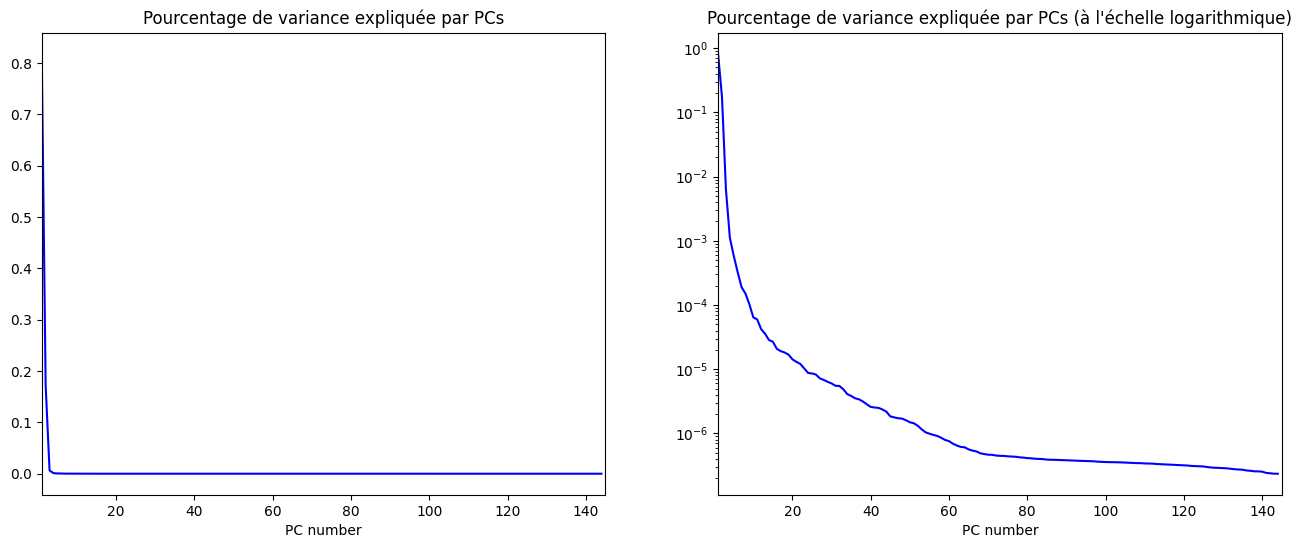

Nombre de composantes principales nécessaires pour expliquer 90% de la variance :
 2


In [5]:
# Redimensioning hsi into a 2D matrix
row, col, dim = hsi_raw.shape
hsi = hsi_raw.reshape(row * col, dim)

# Applying PCA to hsi
hsi_pca = PCA()
hsi_pca.fit(hsi)

# Plotting explained variance ratio per principal components
plt.figure(figsize=(16,6))

plt.subplot(121)
plt.title('Pourcentage de variance expliquée par PCs')
plt.plot(np.arange(1, dim + 1), hsi_pca.explained_variance_ratio_, 'b')
plt.xlabel('PC number')
plt.xlim(1, dim + 1)

plt.subplot(122)
plt.title("Pourcentage de variance expliquée par PCs (à l'échelle logarithmique)")
plt.plot(np.arange(1, dim + 1), hsi_pca.explained_variance_ratio_, 'b')
plt.xlabel('PC number')
plt.xlim(1, dim + 1)
plt.yscale('log')

plt.show()

# Finding how many PCs we need
var_cumsum = hsi_pca.explained_variance_ratio_.cumsum()
percofvar = 0.9
nbPCs = np.where(var_cumsum > percofvar)[0][0] + 1
print("Nombre de composantes principales nécessaires pour expliquer 90% de la variance :\n", nbPCs)

Nous pouvons alors observer que la majorité de la variance de notre ensemble de caractéristiques peut être expliquée par un faible nombre de composantes principales.

Plus particulièrement, nous n'avons besoin que de deux composantes principales pour expliquer 90% de la variance.

Ainsi, nous réduisons la dimension de notre ensemble de caractéristiques de 144 à 2, en prenant pour chaque pixel les deux premières composantes résultantes de l'application du PCA, visibles ci-dessous.

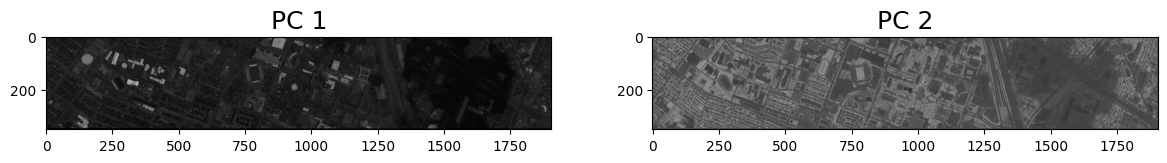

In [6]:
# Getting reduced dimension hsi
hsi_trans = hsi_pca.transform(hsi)[:, :nbPCs]
hsi_proj = hsi_trans.reshape((row, col, nbPCs))

# Plotting principal components of hci
plt.figure(figsize=(30,15))
for i in range(nbPCs):
    plt.subplot(2, 4, i + 1)
    plt.title('PC %d'%(i + 1), fontsize=18)
    plt.imshow(hsi_proj[:, :, i], cmap='gray')
plt.show()

### B. Traitements des nuages

Un second problème qui se pose sont les zones d'assombrissement visibles sur nos composantes principales, surement dues à la présence de nuages lors de la prise de l'image hyperspectrale.

Ces zones d'assombrissement peuvent faussées les prédictions effectuées sur les pixels, leurs valeurs sur le spectre éléctromagnétique dans ces zones différant des valeurs obtenues en dehors pour les mêmes objets.

Ainsi, nous pouvons tenter de rassembler les deux composantes principales de l'image hyperspectrale en les sommant dans un premier temps, puis de seuiller l'image résultante pour obtenir une représentation grossière des zones d'assombrissement.

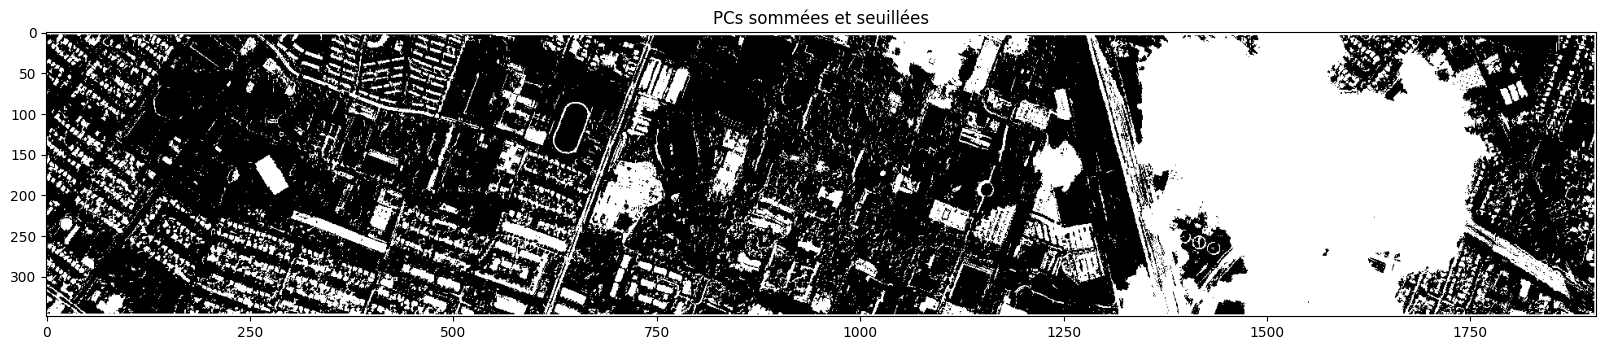

In [7]:
## Finding cloud areas

# Filtering hsi by threshold to find approx of cloud areas
hsi_summed = hsi_trans.sum(axis=1)
hsi_filtered = ((hsi_summed / hsi_summed.max()) < -0.02).astype(float) # -0.02 was chosen arbitrarily
hsi_filtered = hsi_filtered.reshape((row, col))

# Plotting hsi filtered by threshold
plt.figure(figsize=(20,5))
plt.title("PCs sommées et seuillées")
plt.imshow(hsi_filtered, cmap='gray')
plt.show()

Nous pouvons ensuite néttoyer l'image résultante en usant d'opérations de morphologie mathématiques (erosion, fermeture, ouverture) dans un premier temps, et en supprimant les zones de bruit restantes dans un second temps.

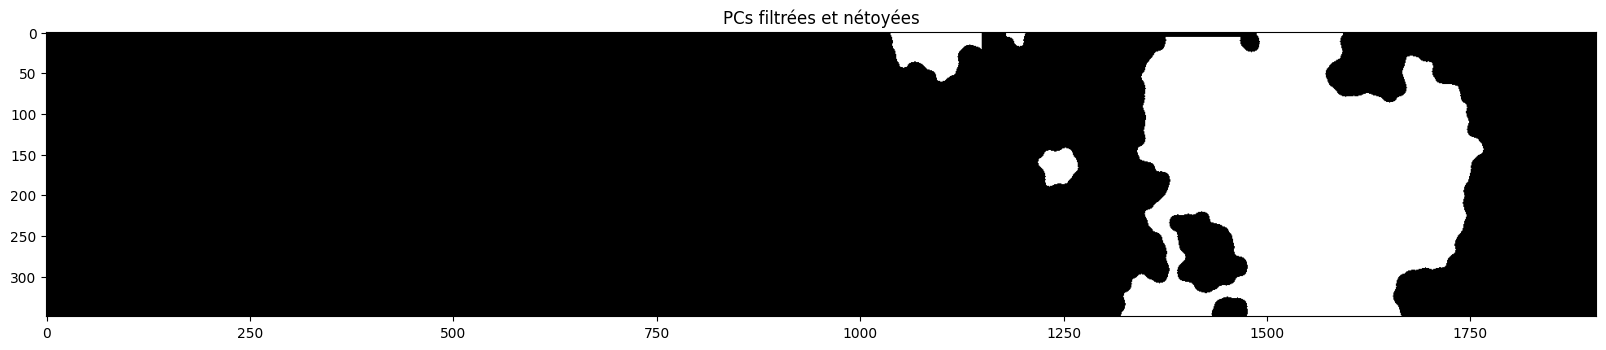

In [8]:
# Cleaning filtered hsi by morpho
hsi_morph = erosion(hsi_filtered, disk(4))
hsi_morph = closing(hsi_morph, disk(10))
hsi_morph = opening(hsi_morph, disk(5))

# Cleaning remaining noise in filtered hsi to obtain cloud areas
hsi_morph[:, :1000] = 0
hsi_morph[200:, 1000:1250] = 0
hsi_morph[:100, 1150:1180] = 0
hsi_morph[30:80, 1130:1200] = 0
hsi_morph[:6, 1300:1470] = 0
hsi_morph[250:300, 1600:1650] = 1

hsi_cloud_area = hsi_morph.copy() 

# Plotting cloud area
plt.figure(figsize=(20,5))
plt.title("PCs filtrées et nétoyées")
plt.imshow(hsi_cloud_area, cmap='gray')
plt.show()

Nous pouvons enfin supprimer les zones d'assombrissement en appliquant l' "Egalisation Adaptative d'Histogramme" (= Adaptative Histogram Equalization, AHE) sur les dites-zones dans un premier temps, puis sur les zones non-assombries dans un second temps. 

L'Egalisation Adaptative d'Histogramme est une méthode de traitement d'image utilisée pour améliorer leur contraste et leur visibilité. 

Dans notre situation, elle permet d'améliorer le contraste et la luminosité des zones assombries, puis de réhausser le contraste et la luminosité de l'ensemble de l'image pour qu'elles soient similaires en toute part de celle-ci.

Ainsi, nous obtenons bien nos deux composantes principales sans zones d'assombrissement, visibles ci-dessous.

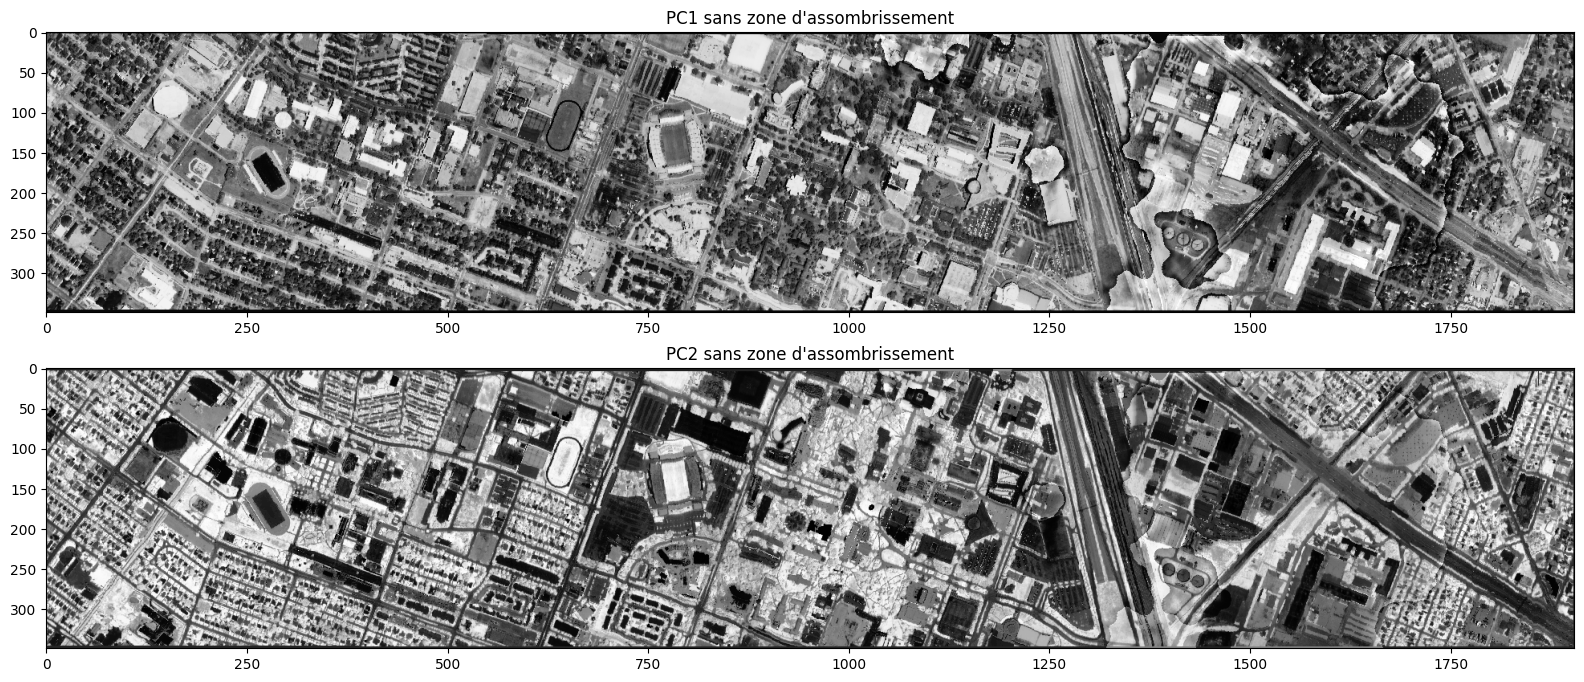

In [9]:
## Clearing cloud areas

# Reshaping hsi_cloud_area in a 1D array of 0s and 1s
hsi_cloud_area = (hsi_cloud_area.reshape(row * col)).astype(int)

# Normalizing hsi for sickit functions to be applied on
hsi_normalized = (hsi_trans - hsi_trans.min()) / (hsi_trans.max() - hsi_trans.min())

# Extracting pc1 and pc2
pc1 = hsi_normalized[:, 0]
pc2 = hsi_normalized[:, 1]

# Performing Adaptive Histogram Equalization (AHE) on the cloud areas to brighten and contrast them
pc1[hsi_cloud_area == 1] = equalize_adapthist(pc1[hsi_cloud_area == 1], clip_limit=0.03)
pc2[hsi_cloud_area == 1] = equalize_adapthist(pc2[hsi_cloud_area == 1], clip_limit=0.03)

# Performing Adaptive Histogram Equalization (AHE) on the non-cloud areas 
# to match the brightness and the contrast of the cloud areas
pc1[hsi_cloud_area == 0] = equalize_adapthist(pc1[hsi_cloud_area == 0], clip_limit=0.03)
pc2[hsi_cloud_area == 0] = equalize_adapthist(pc2[hsi_cloud_area == 0], clip_limit=0.03)

# Putting modified pc1 and pc2 into normalized hsi
hsi_normalized[:, 0] = pc1
hsi_normalized[:, 1] = pc2

# Reshaping hsi_normalized in a plottable 3D array
hsi_proj = hsi_normalized.reshape((row, col, nbPCs))

# Plotting principal components of hci
plt.figure(figsize=(20,8))
plt.subplot(211)
plt.title("PC1 sans zone d'assombrissement")
plt.imshow(hsi_proj[:, :, 0], cmap='gray')

plt.subplot(212)
plt.title("PC2 sans zone d'assombrissement")
plt.imshow(hsi_proj[:, :, 1], cmap='gray')

plt.show()

## II. Traitements de l'Image LiDAR

L'image LiDAR peut quant à elle être représentée par une matrice de 349 lignes et de 1905 colonnes, où les données y étant présentes indiquent la distance des pixels composant les objets visibles au capteur ayant pris l'image, visible ci-dessous.

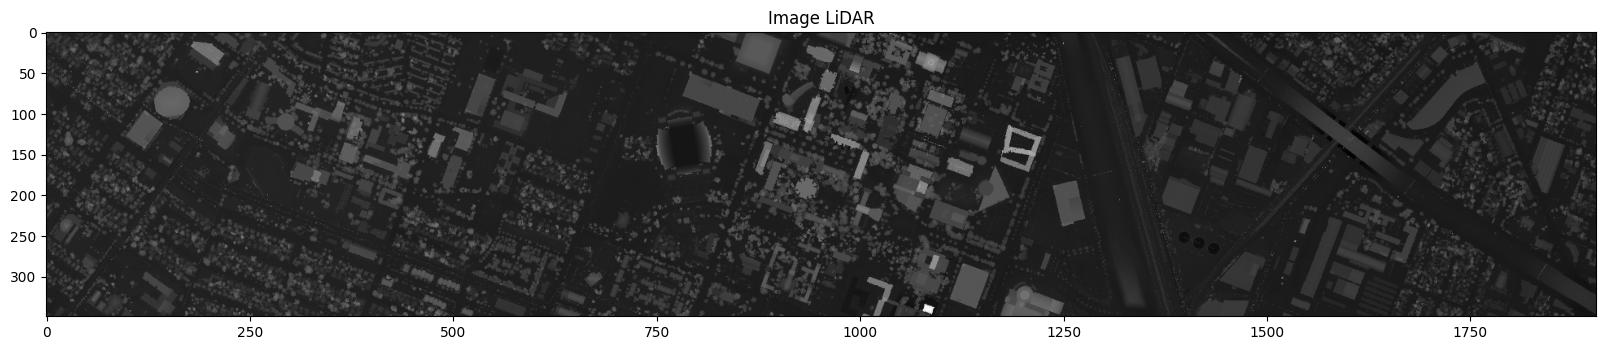

In [10]:
## Merging LiDAR image (= li) with Hyperspectral image

li_raw = data['lidar']

# Plotting li in rgb bands
plt.figure(figsize=(20,5))
plt.title("Image LiDAR")
plt.imshow(li_raw, cmap='gray')
plt.show()

Cette information sur la hauteur des objets est un complément important à l'information spectrale, faisant par ailleurs abstraction des zones d'assombrissement, permettant au classifieur de mieux identifier la classe des différents pixels.

Nous l'incluons alors dans notre cube représentant l'image hyperspectrale réduite de profondeur de 2, passant à une profondeur de 3, où les caractéristiques de chaque pixel sont la première et la seconde composantes principales, ainsi que l'information sur la hauteur de l'image LiDAR.

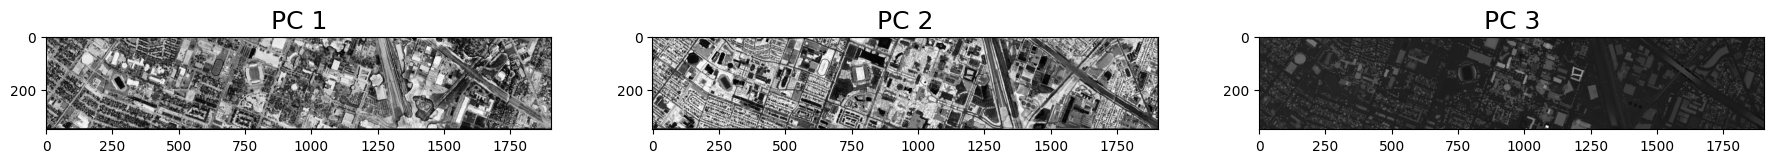

In [11]:
# Redimensioning groundtruth into a 1D array
li = li_raw.reshape(row * col)

# Merging hsi and li
hsi_li = np.column_stack((hsi_normalized, li))
nbPCs = 3
hsi_li_proj = hsi_li.reshape((row, col, nbPCs))

# Plotting principal components of hci_li
plt.figure(figsize=(30,15))
for i in range(nbPCs):
    plt.subplot(2, 4, i + 1)
    plt.title('PC %d'%(i + 1), fontsize=18)
    plt.imshow(hsi_li_proj[:, :, i], cmap='gray')
plt.show()

## III. Classification

Notre ensemble de données regroupant les deux composantes principales de l'image hyperspectrale et l'image LiDAR étant créé, il ne nous reste plus qu'à classifier nos pixels.

Pour cela, nous allons d'abord créer un ensemble de données d'entrainement et de données test à passer au classifieur, à partir des pixels dont nous connaissons la classe décrite dans notre vérité de terrain.

Nous pouvons ensuite tester si nos données d'entrainement sont équilibrées, pouvant être un indicateur de leur qualité. En effet, cela peut éviter que notre classifieur ait des biais d'attribution vers les classes représentées majoritairement dans notre image.

In [12]:
## Applying classification to hsi_li

# Redimensioning groundtruth into a 1D array
row2, col2 = groundtruth_raw.shape
groundtruth = groundtruth_raw.reshape(row2 * col2)

# Creating train and test set
hsi_li_grnd = hsi_li[groundtruth > 0]
hsi_li_grnd_labels = groundtruth[groundtruth > 0]

hsi_li_train, hsi_li_test, hsi_li_labels_train, hsi_li_labels_test = train_test_split(hsi_li_grnd, hsi_li_grnd_labels, 
                                                    test_size=0.25, random_state=42)

# Checking if train set is balanced
_, counts = np.unique(hsi_li_labels_train, return_counts=True)
proportions = (counts / len(hsi_li_labels_train)) * 100
print("Echantillons par classe :\n\n", np.around(proportions, decimals=2))

Echantillons par classe :

 [7.44 6.64 6.59 6.83 6.59 6.45 6.97 6.4  7.11 6.45 6.45 6.64 6.5  6.21
 6.73]


Nous pouvons constater qu'il y a environ 7% d'échantillons par classe dans nos données d'entrainement. Elles sont donc bien équilibrées.

Il existe maintenant beaucoup de modèles de classification superivée sur plusieurs classes. 

Un modèle connu est la classification linéaire, effectuée notamment par le "Classifieur de Descente de Gradient Stochastique" (= Stochastic Gradient Descent Classifier, SGDClassifier), modélisant les relations entre les données en entrée et les classes en sortie à l'aide d'une fonction linéaire.

Ce classifieur fonctionne alors bien sur les données linéairement séparables, clairement distinctes et dispersées, et il fonctionne mal sur les données qui ne le sont pas.

Entrainons un SGDClassifier avec nos données d'entrainement. Nous pouvons ensuite effectuer un premier test de précision en évaluant son score de précision.

In [13]:
# Creating pipeline and training SGDClassifier
clf_full = make_pipeline(StandardScaler(), 
                         SGDClassifier(random_state=0,
                                       shuffle=False,
                                       early_stopping=True,
                                       n_jobs=6
                                      ))

clf_full.fit(hsi_li_train, hsi_li_labels_train)

# First check of classifier accuracy
score = clf_full.score(hsi_li_test, hsi_li_labels_test)
print("\nScore de précision du classifieur :\n", score)


Score de précision du classifieur :
 0.4180790960451977


Nous pouvons constater que le premier test de précision n'est pas fructueux. En effet, le score de précision de notre classifieur est d'environ 42%, ce qui est pauvre.

Ce classifieur n'est alors pas adapté à nos données, surement du à la nature de celles-ci, n'étant pas aisément linéairement séparables. Nous n'allons donc pas l'utiliser.

Un autre modèle connu de classification est celle par usage d'arbres de décision, effectuée notamment par le "Classifieur de Forêt Aléatoire" (= Random Forest Classifier). 

Ce classifieur crée plusieurs arbres de décision entrainés independamment à partir de sous-ensembles des données d'entrainement, dont la prédiction finale est faite en combinant les résultats prédictifs de ces arbres.

Il s'adapte bien à un large pannel de données et de situations, et effectue généralement des prédictions robustes.

Entrainons un RandomForestClassifier avec nos données d'entrainement, et testons ensuite sa précision avec un premier test sur son score de précision.

In [14]:
# Training RandomForestClassifier
clf_full = RandomForestClassifier(random_state=0)

clf_full.fit(hsi_li_train, hsi_li_labels_train)

# First check of classifier accuracy
score = clf_full.score(hsi_li_test, hsi_li_labels_test)
print("\nScore de précision du classifieur :\n", score)


Score de précision du classifieur :
 0.8813559322033898


Nous pouvons constater que le premier test de précision est très prometteur. En effet, le score de précision de notre classifieur est d'environ 88%, indiquant qu'il serait hautement précis.

Pour en être certain, regardons la matrice de confusion de notre classifieur appliqué à notre ensemble de données test, visible ci-dessous.

Score de précision du classifieur :
 0.8813559322033898 

Scores de précision du classifieur par classe :
 [0.98 0.98 1.   1.   0.96 0.91 0.81 0.98 0.71 0.91 0.68 0.75 0.54 0.98
 1.  ] 

Nombre de classes prédites à plus de 90% de précision :
 10 

Nombre de classes prédites à plus de 75% de précision :
 12 

Classes prédites à moins de 75% de précision :
 [ 9 11 13]


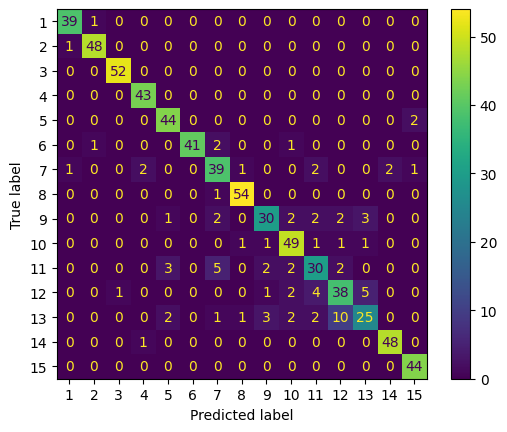

In [15]:
## Second check of classifier accuracy using confusion matrix

# Calculating confusion matrix
conf_matrix = confusion_matrix(hsi_li_labels_test, clf_full.predict(hsi_li_test), labels=[i for i in range(1, 16)])

# Calculating mean accuracy score
score = np.sum(np.diagonal(conf_matrix)) / hsi_li_test.shape[0]

# Calculating mean accuracy score for all classes
score_conf_matrix = np.diagonal(conf_matrix) / conf_matrix.sum(axis=1)
        
# Plotting confusion matrix
ConfusionMatrixDisplay.from_estimator(clf_full, hsi_li_test, hsi_li_labels_test)

# Printing some interesting numbers
print("Score de précision du classifieur :\n", score, "\n")
print("Scores de précision du classifieur par classe :\n", np.around(score_conf_matrix, decimals=2), "\n")
print("Nombre de classes prédites à plus de 90% de précision :\n", len(score_conf_matrix[score_conf_matrix > 0.9]), "\n")
print("Nombre de classes prédites à plus de 75% de précision :\n", len(score_conf_matrix[score_conf_matrix > 0.745]), "\n")
print("Classes prédites à moins de 75% de précision :\n", np.where(score_conf_matrix < 0.745)[0] + 1)

La matrice de confusion nous indique tout d'abord que toutes les classes sont prédites à plus de 50% de précision, notre classifieur n'attribue donc aucune classe de façon aléatoire.

Sur les 15 classes attribuables, 12 sont prédites à plus de 75% de précision dont 10 étant parfaitement prédites, soit la grande majorité des classes de notre modèle.

Nous pouvons cependant noter que trois classes sont prédites avec une précision moyennement haute, entre 50% et 75%, étant la 9, la 11 et la 13, où la 13 n'est prédite qu'avec ~54% de précision, soit près d'une chance sur deux. 

Il serait donc interessant d'envisager de retravailler nos données davantage pour rendre encore plus précis notre modèle.

L'analyse de la matrice de confusion a cependant démontré que notre classifieur est actuellement suffisamment précis pour effectuer des prédictions justes pour la majorité des classes.

Nous pouvons finalement vérifier si notre classifieur est suffisamment précis pour être utilisé sur l'ensemble de notre jeu de données à l'aide d'une métrique prenant en compte le taux de prédictions positifs correctes et le taux de positifs correctement prédits étant le "F1-score".

In [16]:
## Third check of classifier accuracy using F1-score

# Calculating F1-scores per class
F1_score_per_class = f1_score(hsi_li_labels_test, clf_full.predict(hsi_li_test), labels=[i for i in range(1, 16)], average=None)

# Calculating F1-score not taking into account data balance
F1_score_macro = f1_score(hsi_li_labels_test, clf_full.predict(hsi_li_test), labels=[i for i in range(1, 16)], average="macro")

# Calculating F1-score taking into account data balance
F1_score_weighted = f1_score(hsi_li_labels_test, clf_full.predict(hsi_li_test), labels=[i for i in range(1, 16)], average="weighted")

# Printing some interesting numbers
print("F1-scores par classe :\n", np.around(F1_score_per_class, decimals=2), "\n")
print("Nombre de classes prédites à plus de 90% de précision (F1-score) :\n", len(F1_score_per_class[F1_score_per_class > 0.9]), "\n")
print("Nombre de classes prédites à plus de 75% de précision (F1-score) :\n", len(F1_score_per_class[F1_score_per_class > 0.745]), "\n")
print("Classes prédites à moins de 75% de précision (F1-score) :\n", np.where(F1_score_per_class < 0.745)[0] + 1, "\n")
print("F1-score du classifieur ne prenant pas en compte l'équilibre des données :\n", F1_score_macro, "\n")
print("F1-score du classifieur prenant en compte l'équilibre des données :\n", F1_score_weighted)

F1-scores par classe :
 [0.96 0.97 0.99 0.97 0.92 0.95 0.8  0.96 0.76 0.88 0.71 0.73 0.62 0.97
 0.97] 

Nombre de classes prédites à plus de 90% de précision (F1-score) :
 9 

Nombre de classes prédites à plus de 75% de précision (F1-score) :
 12 

Classes prédites à moins de 75% de précision (F1-score) :
 [11 12 13] 

F1-score du classifieur ne prenant pas en compte l'équilibre des données :
 0.876844171312423 

F1-score du classifieur prenant en compte l'équilibre des données :
 0.878098620912238


Les taux de précision trouvés à partir du F1-score et de la matrice de confusion sont relativement similaires, l'analyse par le F1-score montrant également que la majorité des classes est correctement prédite par notre classifieur.

Aussi, nous pouvons observer que les données sont bien équilibrées au vue de la similarité des scores entre celui prenant en compte l'équilibrage et celui ne le faisant pas.

Au final, le F1-score démontre aussi que notre classifieur est capable de correctement prédire les individus positifs par un score élevé, d'environ 88%.

Par l'usage de plusieurs métriques, nous avons donc bien prouvé que notre classifieur est suffisamment précis pour pouvoir classer correctement l'ensemble de notre jeu de données.

Usons alors de notre classifieur sur notre jeu de données et visualisons les résultats.

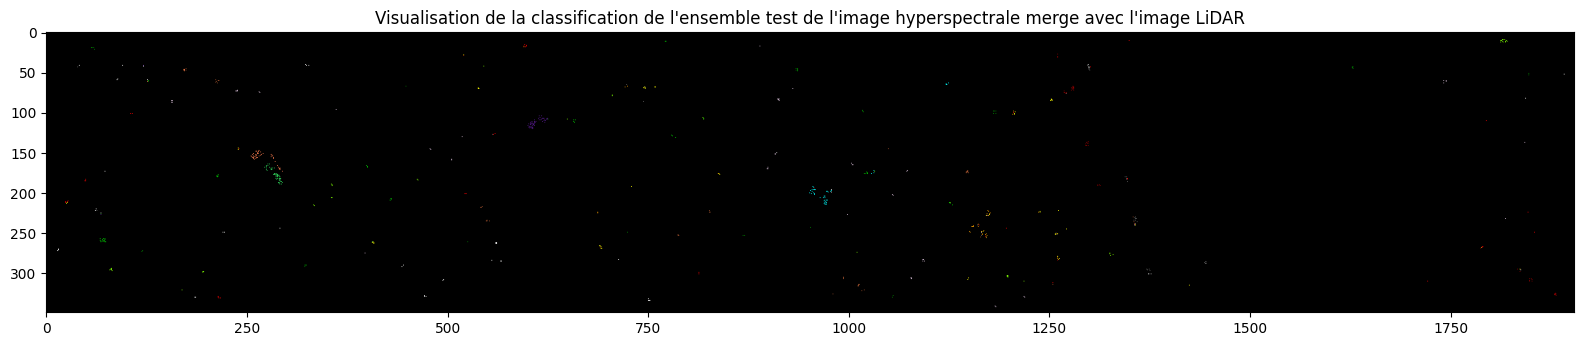

In [17]:
# Function to generate a plottable projection of classified image
def proj_clf_result(img, img_full, background_color):
    img_clf = clf_full.predict(img)
    
    # initialize output array
    img_clf_proj = np.full((img_full.shape[0], 3), background_color, dtype=np.uint8)
    
    for dictionary in groundtruth_info:
        # create a boolean mask for hsi_test_clf that matches the current dictionary's class_label
        mask = img_clf == dictionary['class_label']
        
        if np.any(mask):
            # find the indices of the matching coordinates in hsi_trans
            indices = np.where(np.in1d(img_full, img[mask]).reshape(img_full.shape[0], -1).all(axis=1))[0]
            
            # set the corresponding rows of hsi_test_clf_proj to the dictionary's class_color
            img_clf_proj[indices, :] = dictionary['class_color']
            
    return img_clf_proj

# Plotting classification of hsi_li test set
hsi_li_test_clf_proj = proj_clf_result(hsi_li_test, hsi_li, [0, 0, 0])

hsi_li_test_clf_proj = hsi_li_test_clf_proj / hsi_li_test_clf_proj.max()

hsi_li_test_clf_proj = hsi_li_test_clf_proj.reshape((row, col, 3))

plt.figure(figsize=(20,8))
plt.subplot(211)
plt.title("Visualisation de la classification de l'ensemble test de l'image hyperspectrale merge avec l'image LiDAR")
plt.imshow(hsi_li_test_clf_proj, cmap='jet')
plt.show()

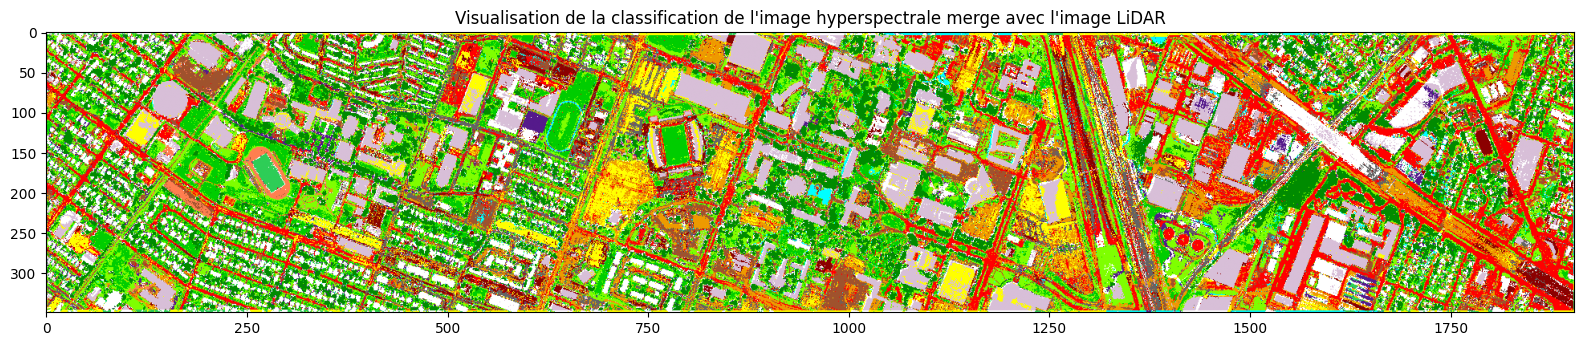

In [18]:
# Plotting classification of hsi_li
hsi_li_clf_proj = proj_clf_result(hsi_li, hsi_li, [0, 0, 0])

hsi_li_clf_proj = hsi_li_clf_proj / hsi_li_clf_proj.max()

hsi_li_clf_proj = hsi_li_clf_proj.reshape((row, col, 3))

plt.figure(figsize=(20,8))
plt.subplot(212)
plt.title("Visualisation de la classification de l'image hyperspectrale merge avec l'image LiDAR")
plt.imshow(hsi_li_clf_proj, cmap='jet')
plt.show()

Nous pouvons observer que le résultat de notre classification semble globalement cohérent. 

Nous pouvons tout de même noter une surabondance de pixels de route (rouge) à droite de l'image, située sur la zone précedemment assombrie du à la présence de nuage.

Nous pouvons aussi noter la présence curieuse de pixels de parking (orange) situé à droite de l'image sur des zones routières, également situés sur la zone précedemment assombrie du à la présence de nuage.

Le traitement des zones assombries, ayant surement augmenté la précision de notre modèle, n'a ainsi pas été parfaitement réalisé. Un meilleur traitement de celles-ci pourrait davantage augmenter la précision de notre classifieur.

Egalement, un jeu de données plus vaste (avec plus de composantes principales par exemple) ou un type de classifieur plus adapté à nos données pourraient aussi augmenter davantage la précision de notre modèle.

## IV. Fonction finale et Export des résultats

Enfin, nous pouvons rassembler notre travail dans une fonction nommée "classification" prenant en entrée les images hyperspectrale et LiDAR ainsi que notre modèle entraîné, et renvoyant en sortie une carte de classification thématique au niveau des pixels, carte que nous allons sauvegarder dans un fichier nommé "prediction.npz".

In [19]:
# Function applying PCA to Hyperspectral image
def principalComponentAnalysis(hsi: "hyperspectral image") :
    
    # Redimensioning hsi into a 2D matrix
    row, col, dim = hsi.shape
    hsi = hsi.reshape(row * col, dim)

    # Applying PCA to hsi
    hsi_pca = PCA()
    hsi_pca.fit(hsi)
    
    # Finding how many PCs we need
    var_cumsum = hsi_pca.explained_variance_ratio_.cumsum()
    percofvar = 0.9
    nbPCs = np.where(var_cumsum > percofvar)[0][0] + 1
    
    # Getting reduced dimension hsi
    hsi_trans = hsi_pca.transform(hsi)[:, :nbPCs]
    
    return hsi_trans

# Function finding cloud areas
def findingCloudAreas(hsi_trans: "reduced dimension hyperspectral image") :

    # Filtering hsi by threshold to find approx of cloud areas
    hsi_summed = hsi_trans.sum(axis=1)
    hsi_filtered = ((hsi_summed / hsi_summed.max()) < -0.02).astype(float) # -0.02 was chosen arbitrarily
    hsi_filtered = hsi_filtered.reshape((row, col))
    
    # Cleaning filtered hsi by morpho
    hsi_morph = erosion(hsi_filtered, disk(4))
    hsi_morph = closing(hsi_morph, disk(10))
    hsi_morph = opening(hsi_morph, disk(5))

    # Cleaning remaining noise in filtered hsi to obtain cloud areas
    hsi_morph[:, :1000] = 0
    hsi_morph[200:, 1000:1250] = 0
    hsi_morph[:100, 1150:1180] = 0
    hsi_morph[30:80, 1130:1200] = 0
    hsi_morph[:6, 1300:1470] = 0
    hsi_morph[250:300, 1600:1650] = 1

    return hsi_morph

# Function clearing cloud areas
def clearingCloudAreas(hsi_cloud_area: "mask of the cloud areas") :
    
    # Reshaping hsi_cloud_area in a 1D array of 0s and 1s
    hsi_cloud_area = (hsi_cloud_area.reshape(row * col)).astype(int)

    # Normalizing hsi for sickit functions to be applied on
    hsi_normalized = (hsi_trans - hsi_trans.min()) / (hsi_trans.max() - hsi_trans.min())

    # Extracting pc1 and pc2
    pc1 = hsi_normalized[:, 0]
    pc2 = hsi_normalized[:, 1]

    # Performing Adaptive Histogram Equalization (AHE) on the cloud areas to brighten and contrast them
    pc1[hsi_cloud_area == 1] = equalize_adapthist(pc1[hsi_cloud_area == 1], clip_limit=0.03)
    pc2[hsi_cloud_area == 1] = equalize_adapthist(pc2[hsi_cloud_area == 1], clip_limit=0.03)

    # Performing Adaptive Histogram Equalization (AHE) on the non-cloud areas 
    # to match the brightness and the contrast of the cloud areas
    pc1[hsi_cloud_area == 0] = equalize_adapthist(pc1[hsi_cloud_area == 0], clip_limit=0.03)
    pc2[hsi_cloud_area == 0] = equalize_adapthist(pc2[hsi_cloud_area == 0], clip_limit=0.03)

    # Putting modified pc1 and pc2 into normalized hsi
    hsi_normalized[:, 0] = pc1
    hsi_normalized[:, 1] = pc2
    
    return hsi_normalized

# Function merging Hyperspectral and LiDAR images
def mergingHyperspectralLiDAR(hsi: "hyperspectral image", li: "LiDAR image") :
    
    # Redimensioning groundtruth into a 1D array
    li = li.reshape(row * col)

    # Merging hsi and li
    hsi_li = np.column_stack((hsi_normalized, li))
    
    return hsi_li


### FINAL FUNCTION ###


# Function taking Hyperspectral and LiDAR images as entries, and returning pixels level thematic map
def classification(hsi: "hyperspectral image", li: "LiDAR image", clf: "classifier") :
    ## Applying classification to hsi_li
    
    hsi_trans = principalComponentAnalysis(hsi)
    
    hsi_cloud_area = findingCloudAreas(hsi_trans)
    
    hsi = clearingCloudAreas(hsi_cloud_area)
    
    hsi_li = mergingHyperspectralLiDAR(hsi, li)
    
    return clf.predict(hsi_li).reshape((li.shape[0], li.shape[1]))

In [22]:
## Exporting results

predictions = classification(hsi_raw, li_raw, clf_full)

# Sanity check 1: do predictions have the correct shape?
assert(predictions.shape == groundtruth_raw.shape)

# Sanity check 2: are predicted values in the correct domain?
assert(np.all(np.in1d(predictions.flatten(), np.unique(groundtruth))))

# Export
import os.path
filename_predictions = "predictions.npz"
np.savez_compressed(filename_predictions, data=predictions)
assert(os.path.exists(filename_predictions))

# Sanity check 3: read file again and check its content is consistent
loaded_data = np.load(filename_predictions)['data']
assert(np.allclose(loaded_data, predictions))

## Conclusion

En conclusion, dans le cadre de ce projet, nous devions classifier un ensemble de pixels représentés dans une image hyperspectrale et une image LiDAR.

Pour pouvoir passer nos données à notre classifieur, nous devions traiter nos images au préalable, en réduisant notamment la dimension et en supprimant les zones d'assombrissement de l'image hyperspectrale, ainsi qu'en fusionnant les composantes principales de l'image hyperspectrale et l'image LiDAR.

Nous devions ensuite passer à la recherche d'un type de classifieur adapté à la nature de nos données. Nous avions alors trouvé que le "Classifieur de Forêt Aléatoire" (= Random Forest Classifier) était adapté à notre situation, nous fournissant des résultats précis, précision évaluée par plusieurs métriques.

Nous pouvions enfin passer à la classification de nos données, classification que nous avons effectué dans une fonction finale et que nous avons enregistré dans un fichier "predictions.npz".

Notre modèle comporte néanmoins certaines limites, notamment en ce qui concerne la précision de la classification, n'étant pas optimale pour toutes les classes de notre ensemble de données, pouvant encore être améliorée.